In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import ConcatDataset

from floortrans.loaders import FloorplanSVG
from floortrans.loaders.augmentations import Compose, ResizePaddedTorch, DictToTensor

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear GPU cache to avoid memory errors
torch.cuda.empty_cache()

# Set seed and deterministic behavior to ensure reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('Device:', device)
print('Setup completed')

Device: cuda
Setup completed


# Loading the Data

In [2]:
DATA_PATH = 'data/cubicasa5k/'
IMG_SIZE = (256, 256)

aug = Compose([
    ResizePaddedTorch((0, 0), data_format='dict', size=IMG_SIZE), 
    DictToTensor()
])

train_data = FloorplanSVG(DATA_PATH, 'train.txt', format='lmdb', augmentations=aug)
val_data = FloorplanSVG(DATA_PATH, 'val.txt', format='lmdb', augmentations=aug)
test_data = FloorplanSVG(DATA_PATH, 'test.txt', format='lmdb', augmentations=aug)

# Combine into one dataset
full_data = ConcatDataset([train_data, val_data, test_data])

print('Train Size:', len(train_data))
print('Val Size:', len(val_data))
print('Test Size:', len(test_data))
print('Total Size:', len(full_data))

Train Size: 4200
Val Size: 400
Test Size: 400
Total Size: 5000


In [3]:
print('Image Shape:', train_data[0]['image'].shape)
print('Label Shape:', train_data[0]['label'].shape)


Image Shape: torch.Size([3, 256, 256])
Label Shape: torch.Size([23, 256, 256])


In [4]:
print('Image dtype:', train_data[0]['image'].dtype)
print('Label dtype:', train_data[0]['label'].dtype)

Image dtype: torch.int64
Label dtype: torch.float32


# Visualizing Samples

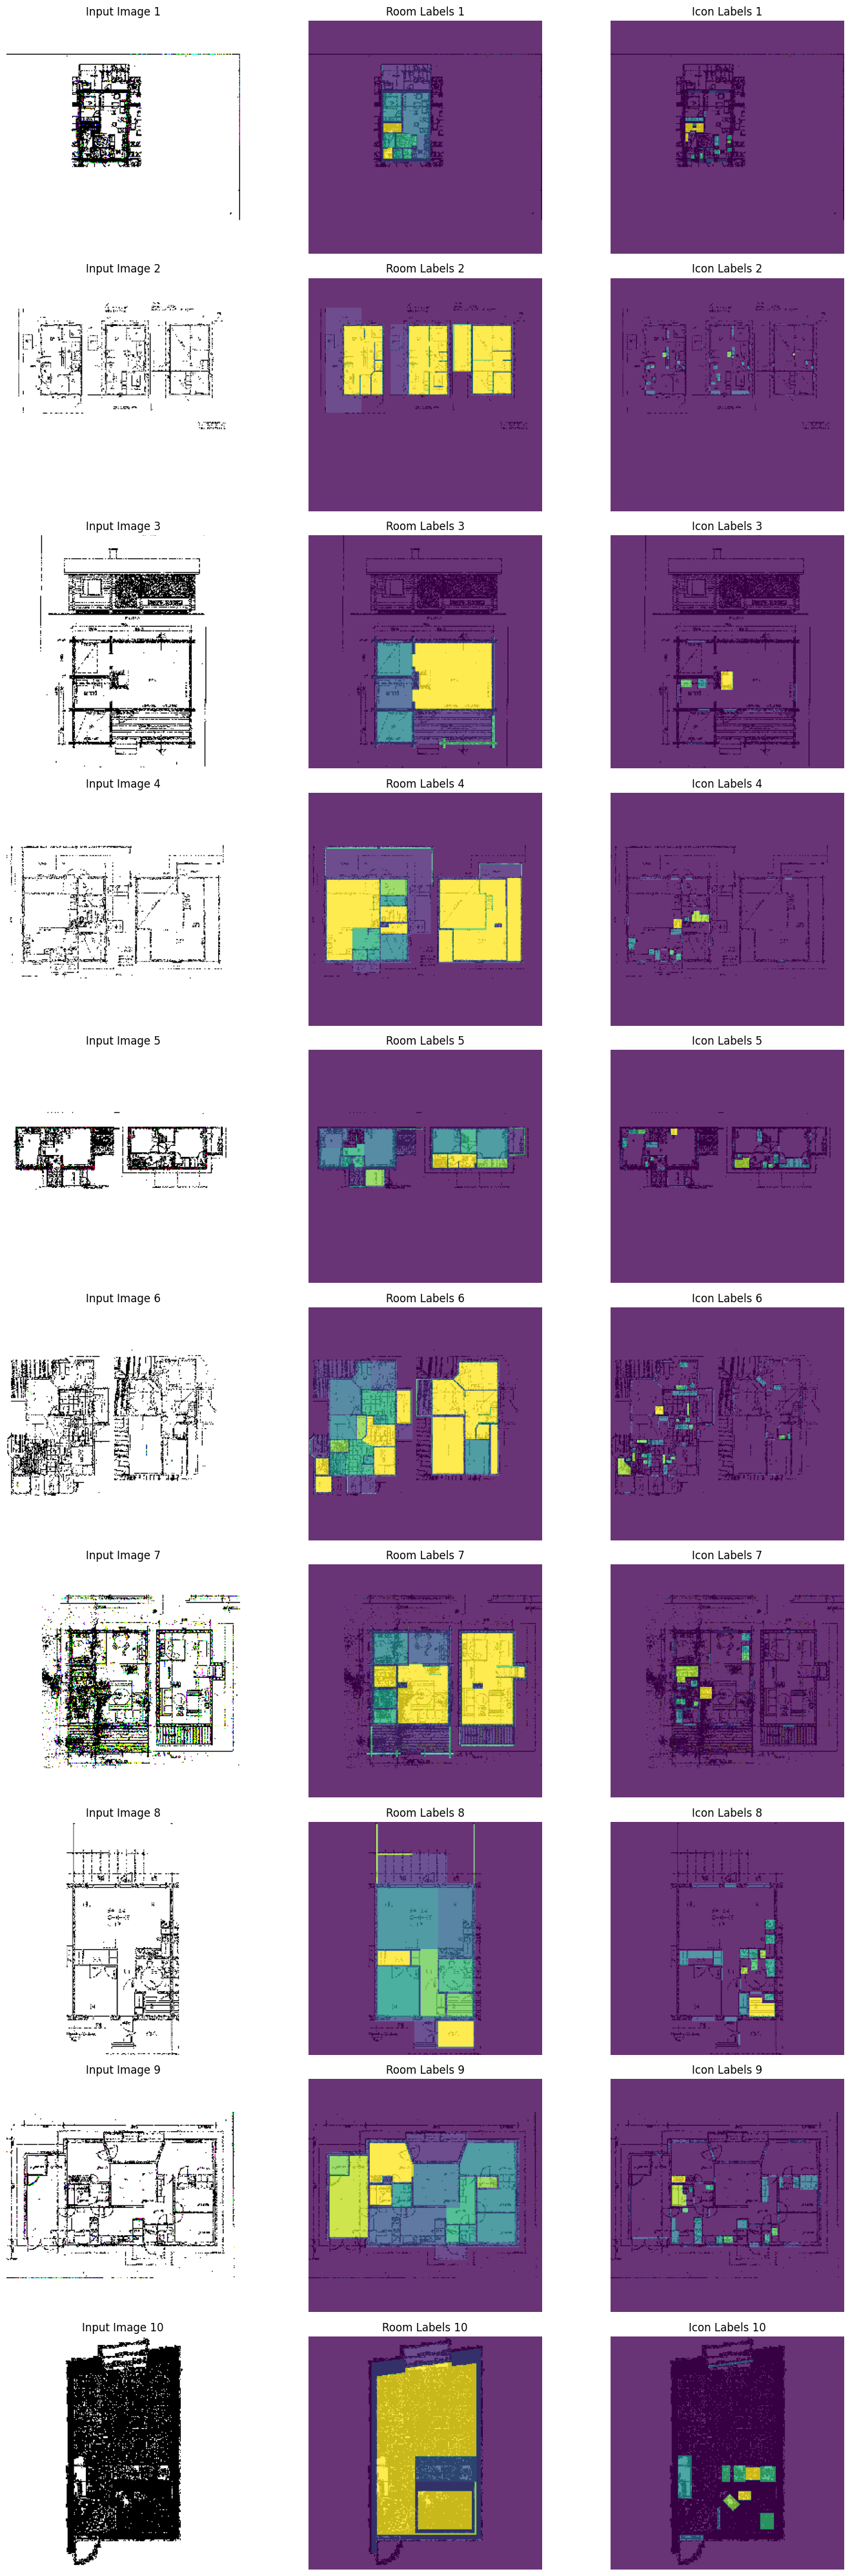

In [5]:
fig, axes = plt.subplots(10, 3, figsize=(15, 40))

for idx in range(10):
    sample = train_data[idx]

    # Convert back to [0, 255] range
    tensor_image = sample['image'] * 255.0
    np_image = tensor_image.numpy().astype(np.uint8)
    np_image = np.transpose(np_image, (1, 2, 0))

    # Input image
    axes[idx, 0].imshow(np_image)
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Input Image {idx+1}')

    # Room segmentation map
    axes[idx, 1].imshow(np_image)
    axes[idx, 1].imshow(sample['label'][21], alpha=0.8)
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title(f'Room Labels {idx+1}')

    # Icon segmentation map
    axes[idx, 2].imshow(np_image)
    axes[idx, 2].imshow(sample['label'][22], alpha=0.8)
    axes[idx, 2].axis('off')
    axes[idx, 2].set_title(f'Icon Labels {idx+1}')

plt.tight_layout()
plt.show()


# Get Class Frequencies

In [6]:
def compute_class_frequencies(dataset, label_index, num_classes, class_names, device="cuda"):
    class_pixel_counts = torch.zeros(num_classes, device=device, dtype=torch.long)
    total_pixels = 0

    for i in tqdm(range(len(dataset)), desc="Computing Frequencies", unit="sample"):
        target = dataset[i]['label'][label_index].long().to(device)

        # Flatten the target and count occurrences of each class
        unique, counts = torch.unique(target, return_counts=True)
        class_pixel_counts[unique] += counts
        total_pixels += target.numel()

    # Calculate percentages
    class_percentages = (class_pixel_counts.float() / total_pixels) * 100

    # Combine results into a dictionary
    class_frequencies = {
        class_names[cls]: {
            "pixel_count": int(class_pixel_counts[cls].item()),
            "percentage": round(float(class_percentages[cls].item()), 4)
        }
        for cls in range(num_classes)
    }

    return class_frequencies


room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room", "Bedroom", "Bath", "Hallway", "Railing", "Storage", "Garage", "Other rooms"]
icon_classes = ["Empty", "Window", "Door", "Closet", "Electr. Appl.", "Toilet", "Sink", "Sauna bench", "Fire Place", "Bathtub", "Chimney"]

train_room_frequencies = compute_class_frequencies(full_data, 21, 12, room_classes, device)
train_icon_frequencies = compute_class_frequencies(full_data, 22, 11, icon_classes, device)

Computing Frequencies: 100%|██████████| 5000/5000 [07:26<00:00, 11.20sample/s]


In [7]:
train_room_frequencies

{'Background': {'pixel_count': 190733374, 'percentage': 58.2072},
 'Outdoor': {'pixel_count': 13069105, 'percentage': 3.9884},
 'Wall': {'pixel_count': 21637374, 'percentage': 6.6032},
 'Kitchen': {'pixel_count': 12693765, 'percentage': 3.8738},
 'Living Room': {'pixel_count': 22485299, 'percentage': 6.862},
 'Bedroom': {'pixel_count': 19815582, 'percentage': 6.0472},
 'Bath': {'pixel_count': 6027099, 'percentage': 1.8393},
 'Hallway': {'pixel_count': 8646111, 'percentage': 2.6386},
 'Railing': {'pixel_count': 845967, 'percentage': 0.2582},
 'Storage': {'pixel_count': 3382997, 'percentage': 1.0324},
 'Garage': {'pixel_count': 1832745, 'percentage': 0.5593},
 'Other rooms': {'pixel_count': 26510582, 'percentage': 8.0904}}

In [8]:
train_icon_frequencies

{'Empty': {'pixel_count': 312538319, 'percentage': 95.3791},
 'Window': {'pixel_count': 3512758, 'percentage': 1.072},
 'Door': {'pixel_count': 1599928, 'percentage': 0.4883},
 'Closet': {'pixel_count': 4635619, 'percentage': 1.4147},
 'Electr. Appl.': {'pixel_count': 2129570, 'percentage': 0.6499},
 'Toilet': {'pixel_count': 504610, 'percentage': 0.154},
 'Sink': {'pixel_count': 853317, 'percentage': 0.2604},
 'Sauna bench': {'pixel_count': 1519713, 'percentage': 0.4638},
 'Fire Place': {'pixel_count': 227349, 'percentage': 0.0694},
 'Bathtub': {'pixel_count': 139037, 'percentage': 0.0424},
 'Chimney': {'pixel_count': 19780, 'percentage': 0.006}}